In [1]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch
from models.EdgeNetWithCategories import EdgeNetWithCategories


In [2]:
def compare_clusters(cluster1, cluster2):
    if len(cluster1) == len(cluster2):
        for i in range(len(cluster1)):
            if cluster1[i] != cluster2[i]:
                return 0
        return 1
    else:
        return 0


In [3]:
def process_file(fname, mdl):
    data = torch.load(fname).to('cuda:0')
    
    with torch.no_grad():
        pred_edges = mdl(data).detach()
        pred_edges_np = pred_edges.cpu().numpy()
        
    #print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
    #print(torch.unique(data.y.cpu(), return_counts=True))
    
    X = data.x.cpu().numpy()
    index = data.edge_index.cpu().numpy().T
    y = data.y.cpu().numpy()

    out = np.argmax(pred_edges_np,axis=-1)

        
    from unionfind import unionfind
    finder_gnn = unionfind(X.shape[0])
    finder_tru = unionfind(X.shape[0])

    Hits_minimum = 3

    for i in tqdm(range(index.shape[0])):
        if out[i] == 1:
            finder_gnn.unite(index[i,0], index[i,1])
        if y[i] == 1:
            finder_tru.unite(index[i,0], index[i,1])

    gnn_roots = np.array([finder_gnn.find(i) for i in range(X.shape[0])], dtype=np.uint32)
    tru_roots = np.array([finder_tru.find(i) for i in range(X.shape[0])], dtype=np.uint32)
    
    tru_clusters = np.unique(tru_roots, return_inverse=True, return_counts=True)
    trus = tru_clusters[0][np.where(tru_clusters[2] >= Hits_minimum)]
    tru_clusters_sel = {i: np.where(tru_roots == tru)[0] for i, tru in enumerate(trus)}

    gnn_clusters = np.unique(gnn_roots, return_inverse=True, return_counts=True)
    gnns = gnn_clusters[0][np.where(gnn_clusters[2] >= Hits_minimum)]
    gnn_clusters_sel = {i: np.where(gnn_roots == gnn)[0] for i, gnn in enumerate(gnns)}

    N_true = len(tru_clusters_sel)
    N_gnn = len(gnn_clusters_sel)

    N_matched = 0
    N_fakes   = 0

    for i in range(N_gnn):
        match = 0
        for j in range(N_true):
            if compare_clusters(gnn_clusters_sel[i], tru_clusters_sel[j]):
                match = 1
        if match == 1:
            N_matched = N_matched+1   
        else:
            N_fakes = N_fakes+1


    track_efficiency = N_matched / N_true
    fake_fraction = N_fakes / N_gnn

#     print("Track Efficiency is " + str(track_efficiency))
#     print("Fake Fraction is " + str(fake_fraction))
    
    return track_efficiency, fake_fraction

In [4]:
def process_all_pt_data(pt):
    dataset = 'detector_pt%.1f' %pt
    model_fname = '/data/gnn_code/hgcal_ldrd/output/'+str(dataset)+'/checkpoints/model_checkpoint_EdgeNetWithCategories_259075_140efb4178_markus.best.pth.tar'
    mdl = EdgeNetWithCategories(input_dim=3, hidden_dim=64, output_dim=2, n_iters=6).to('cuda:0')
    mdl.load_state_dict(torch.load(model_fname)['model'])
    mdl.eval()

    for i in range(100):
        fname = '/data/gnn_code/training_data/'+dataset+'/processed/data_'+str(i)+'.pt'
    #     print(fname)
        file_results = process_file(fname, mdl)

        if i == 0:
            efficiency = file_results[0]
            fake       = file_results[1]

        else:
            efficiency = np.append(efficiency, file_results[0])
            fake       = np.append(fake,       file_results[1])
    
    return efficiency.mean(), efficiency.std(), fake.mean(), fake.std()

In [5]:
pt = 0.5
while (pt <= 5):
    model_results = process_all_pt_data(pt)

    if pt == 0.5:
        pt_array     = pt
        efficiency   = model_results[0]
        efficiency_e = model_results[1]
        fake         = model_results[2]
        fake_e       = model_results[3]

    else:
        pt_array     = np.append(pt_array,     pt)
        efficiency   = np.append(efficiency,   model_results[0])
        efficiency_e = np.append(efficiency_e, model_results[1])
        fake         = np.append(fake,         model_results[2])
        fake_e       = np.append(fake_e,       model_results[3])
    
    pt += .5
    


/home/markus/miniconda3/envs/hgcal-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [6]:
print(pt_array)
print(efficiency)
print(fake)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.68638065 0.92786649 0.97835111 0.99619261 0.99682559 0.99621672
 0.99586041 0.98755284 0.98493836 0.98853574]
[0.21939248 0.04757089 0.01401195 0.0025411  0.00226357 0.00228897
 0.00239728 0.00775215 0.01029624 0.00733837]


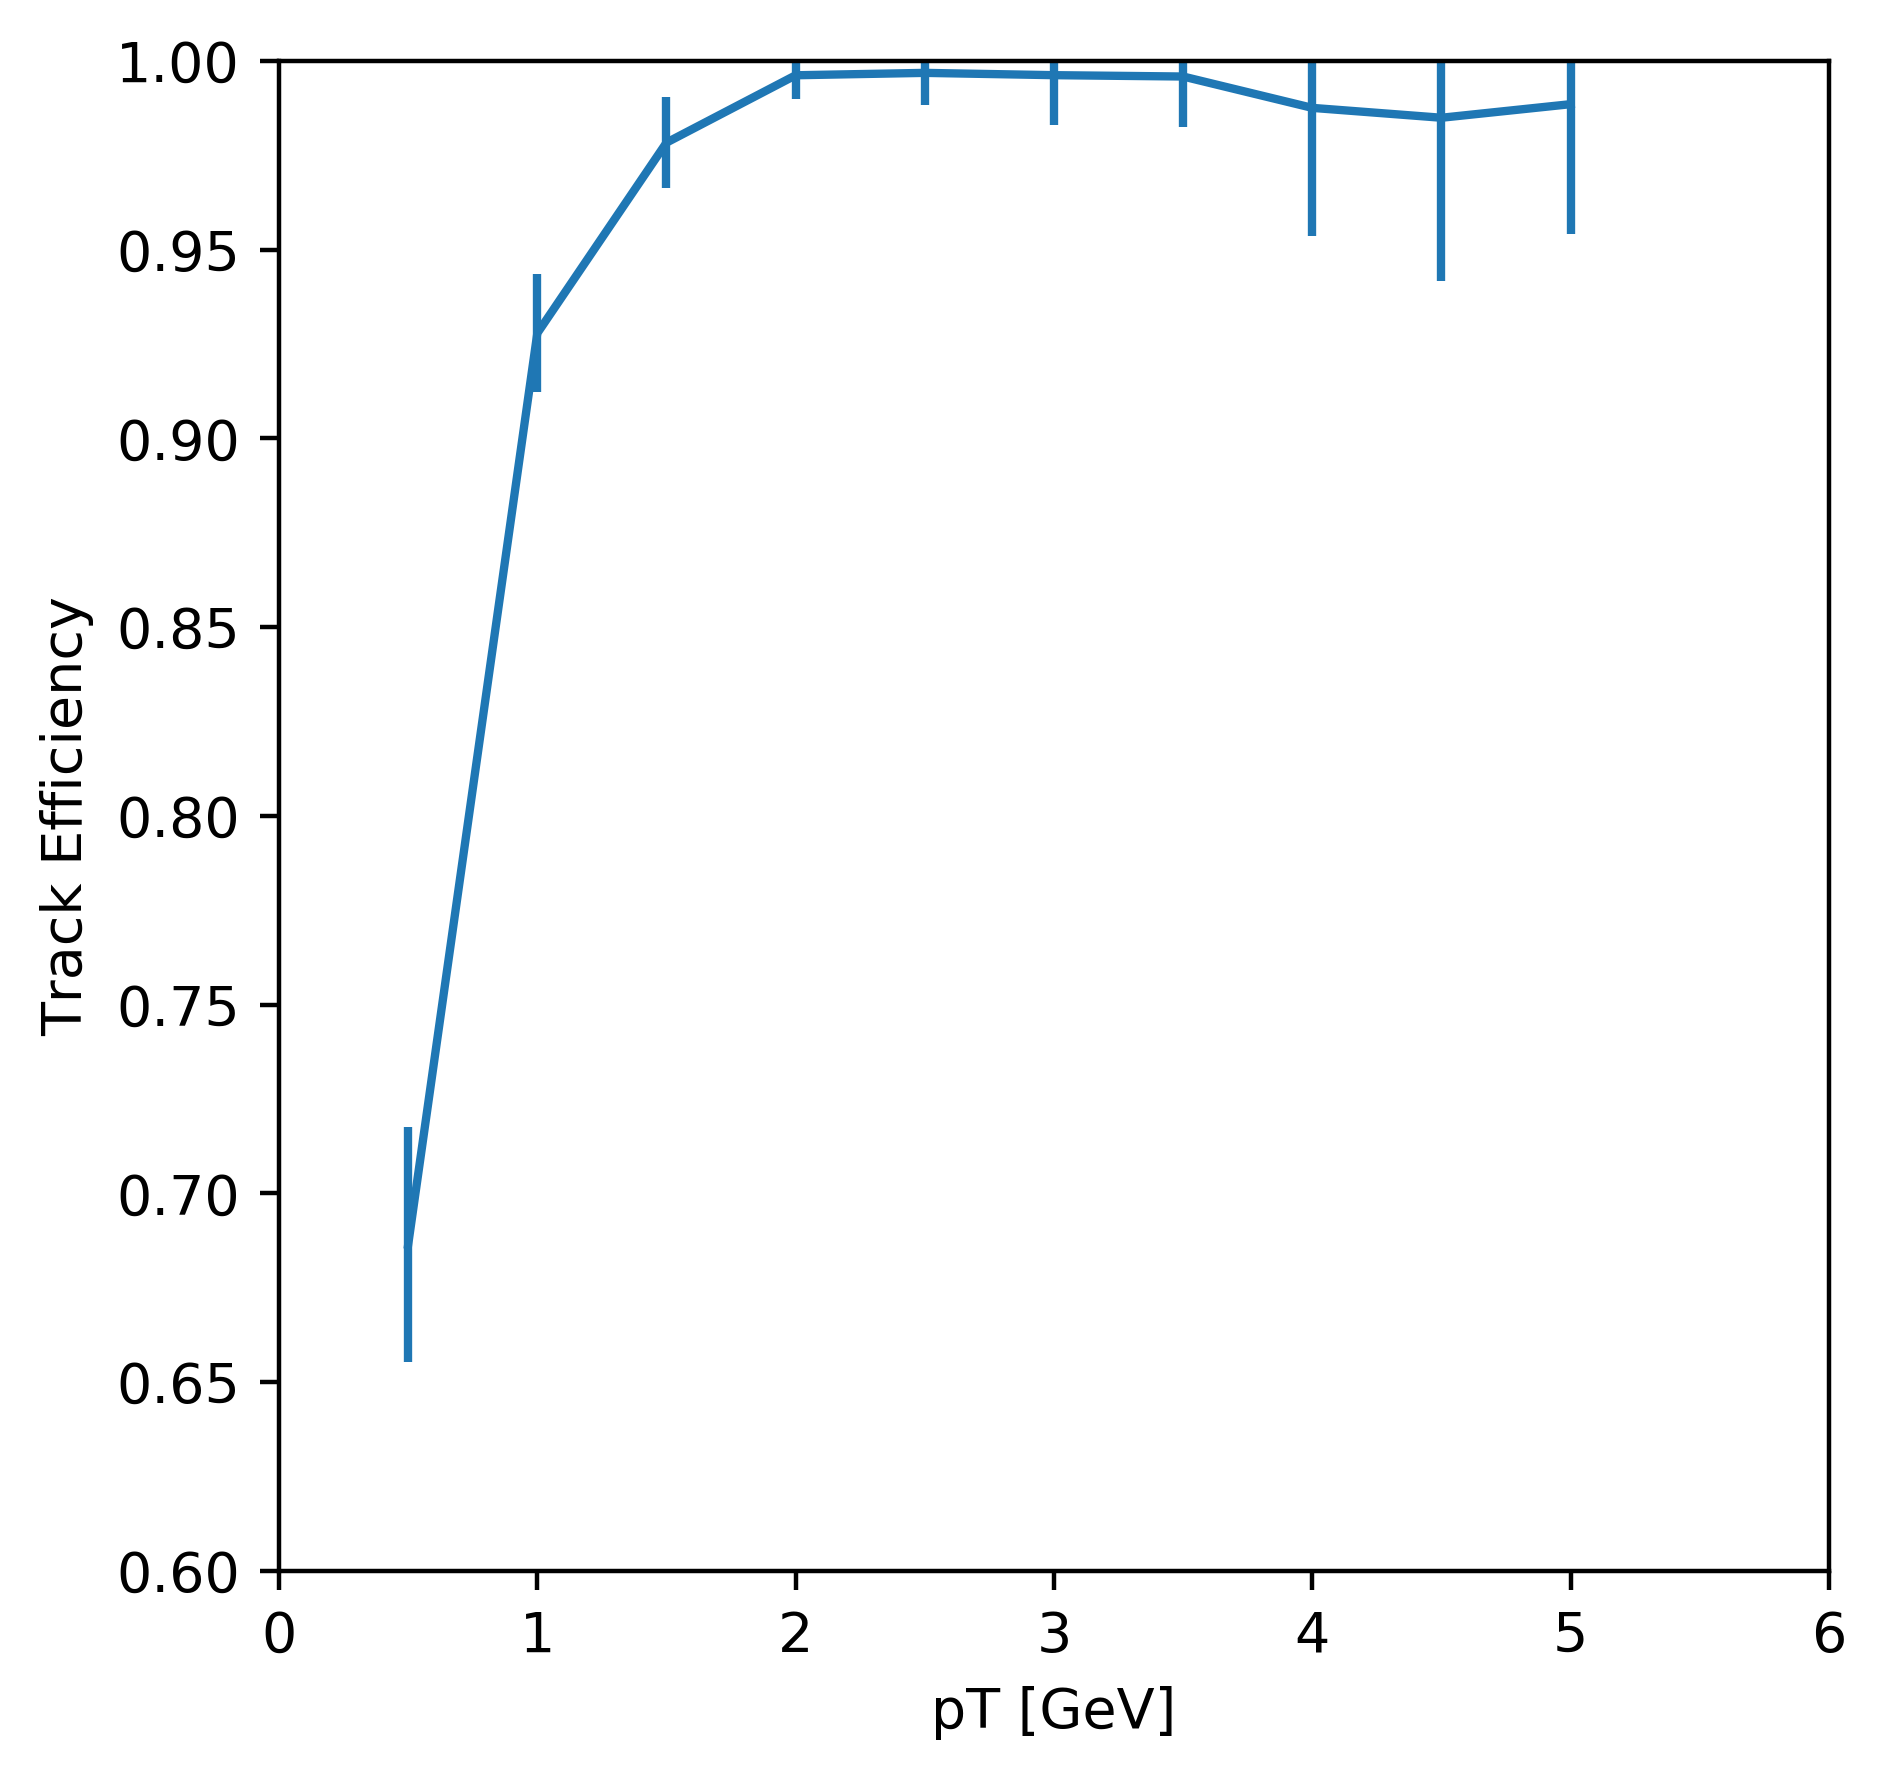

In [15]:
import matplotlib.pyplot as plt
fig, (ax0) = plt.subplots(1, 1, dpi=400, figsize=(5, 5))

# Adjust axes
ax0.set_xlabel('pT [GeV]')
ax0.set_ylabel('Track Efficiency')
ax0.set_xlim(0, 6)
ax0.set_ylim(.6, 1)

#plot points
ax0.errorbar(pt_array, efficiency, efficiency_e)

fig.savefig('/data/gnn_code/hgcal_ldrd/plots/pt_track_efficiency.png')

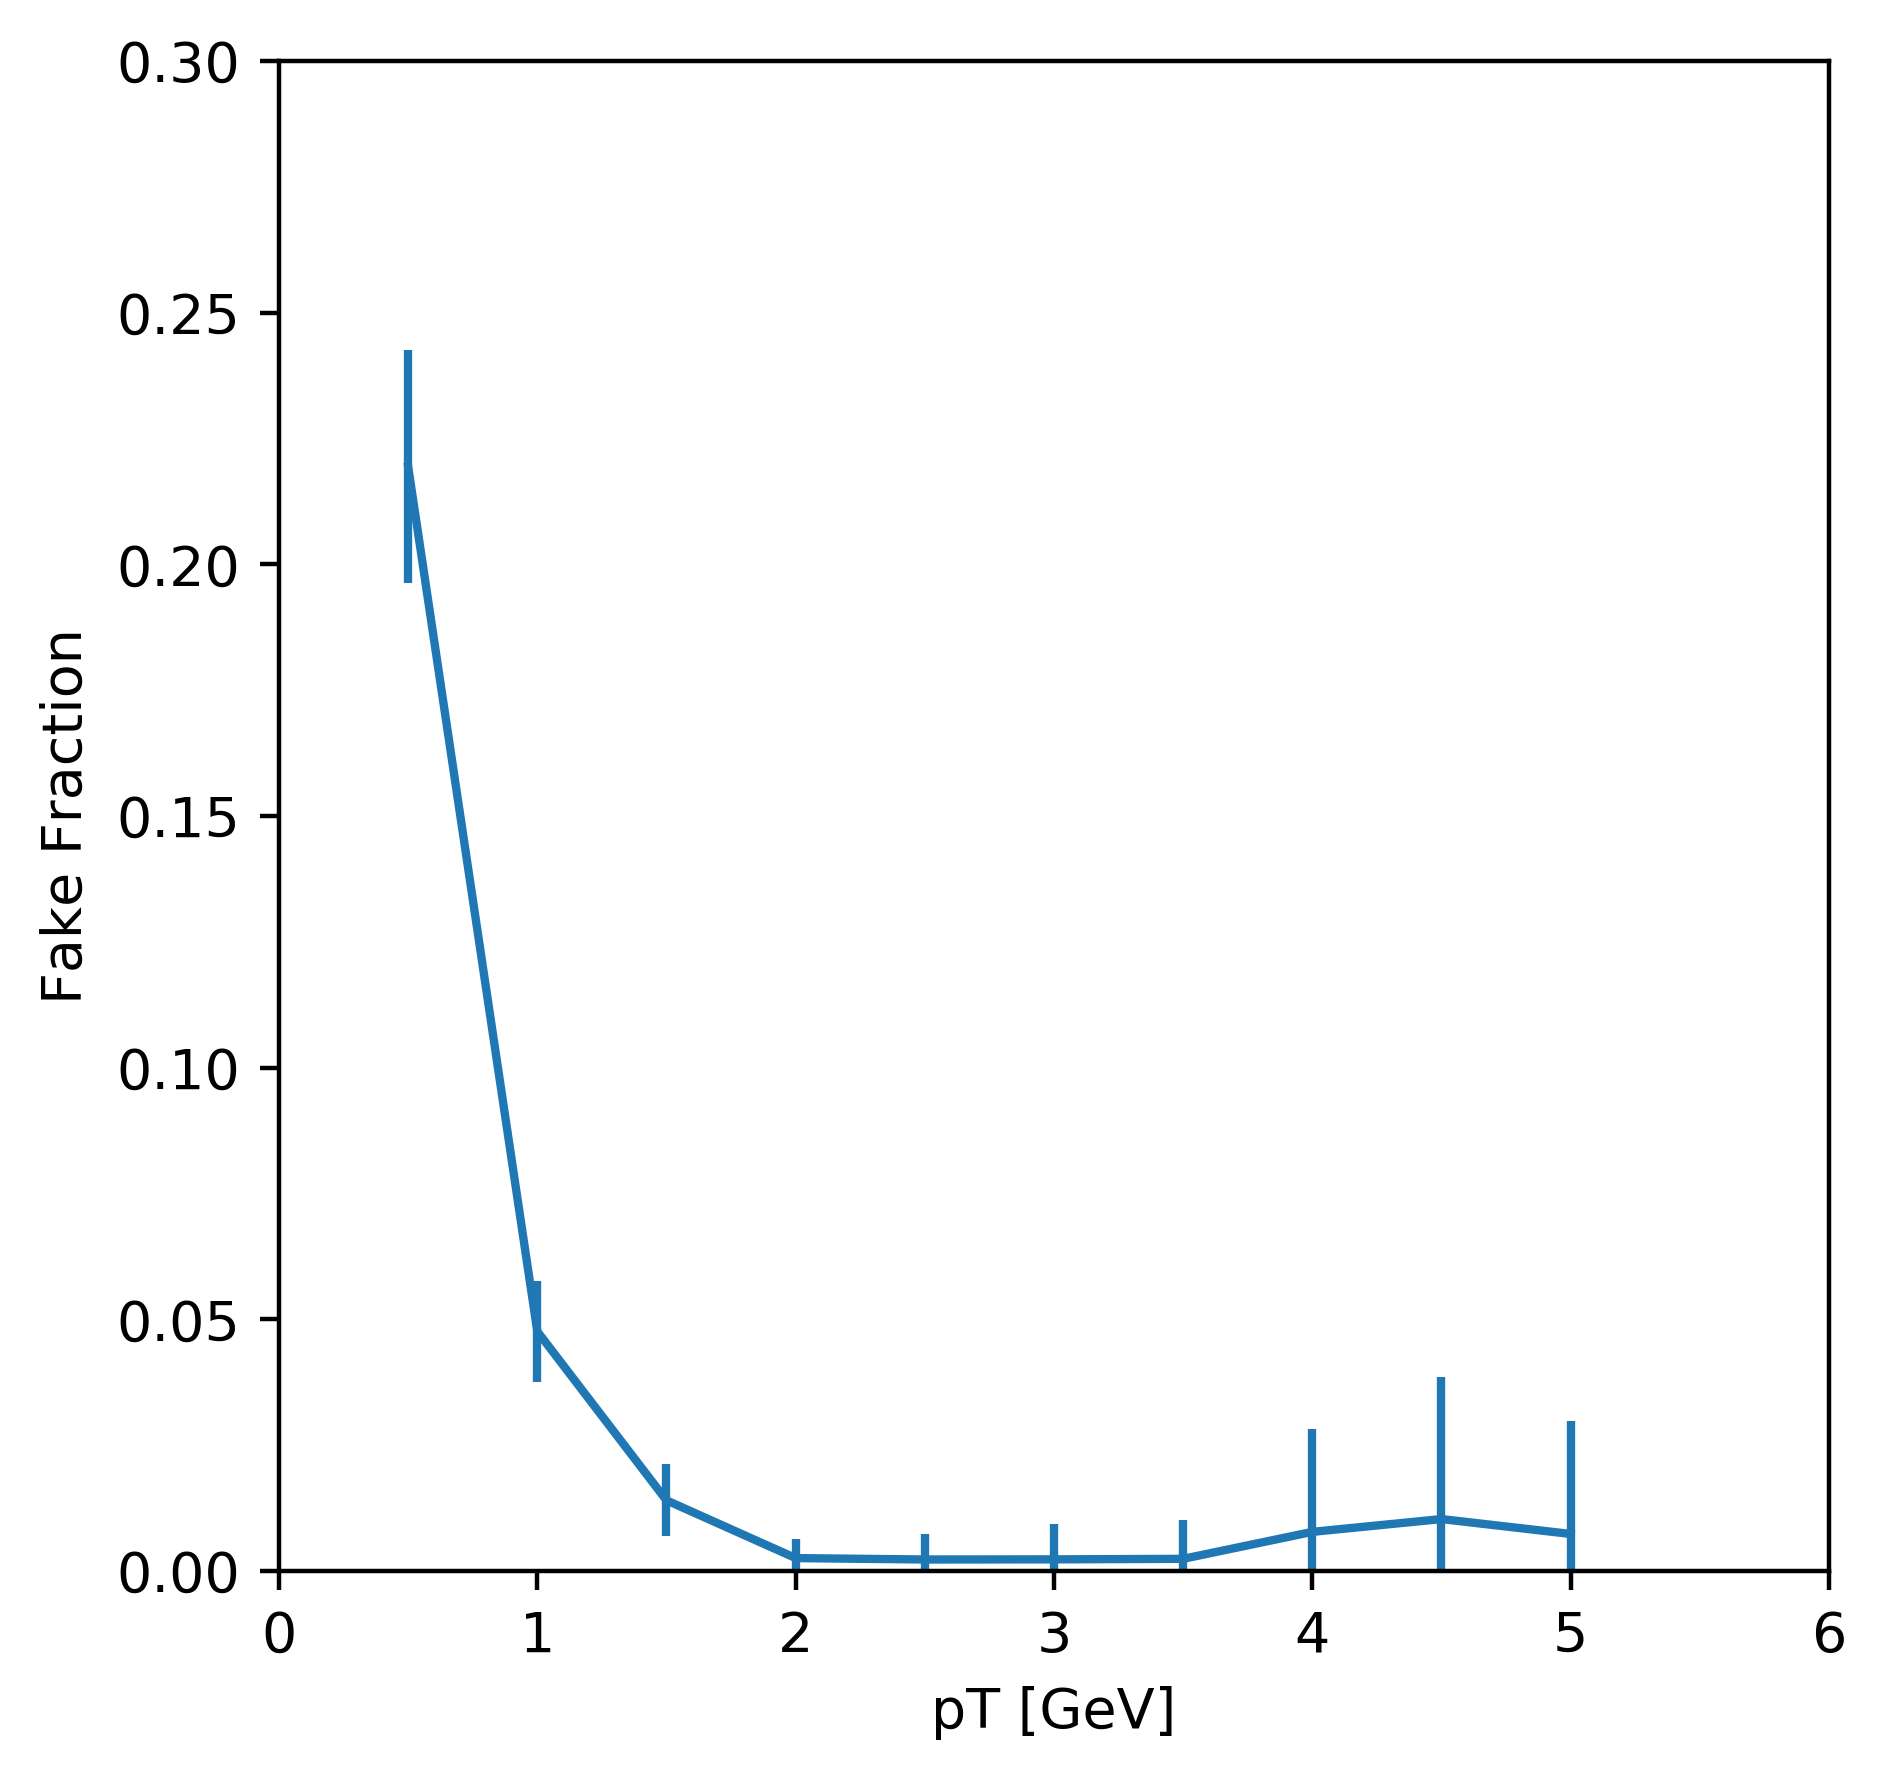

In [16]:
import matplotlib.pyplot as plt
fig, (ax0) = plt.subplots(1, 1, dpi=400, figsize=(5, 5))

# Adjust axes
ax0.set_xlabel('pT [GeV]')
ax0.set_ylabel('Fake Fraction')
ax0.set_xlim(0, 6)
ax0.set_ylim(0, .3)

#plot points
ax0.errorbar(pt_array, fake, fake_e)

fig.savefig('/data/gnn_code/hgcal_ldrd/plots/pt_fake_fraction.png')